In [1]:
import os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gmean

In [2]:
baseDir = r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study'
with open(os.path.join(baseDir, 'Codes','BuildingNames.txt'), 'r') as f:
    BuildingList = f.read() 
BuildingList = BuildingList.split('\n')
BuildingList

['s1_48x32_high',
 's1_48x32_veryhigh',
 's1_96x48_high',
 's1_96x48_veryhigh',
 's2_48x32_high',
 's2_48x32_veryhigh',
 's2_96x48_high',
 's2_96x48_veryhigh',
 's4_96x48_high',
 's4_96x48_veryhigh']

In [3]:
T = np.array([0.13, 0.12, 0.16, 0.15, 0.22, 0.22, 0.26, 0.25, 0.49, 0.49])
numGM = 826
g = 980.665 ## converts GM record to cm/sec^2

def compute_RotDxx_EDP(edpX, edpZ, percentile = 50):
    angles = np.arange(0, 180, step=1)
    radians = np.radians(angles)
    coeffs = np.c_[np.cos(radians), np.sin(radians)]
    
    edp_stacked = np.vstack([edpX, edpZ])
    rotated_edp = np.dot(coeffs, edp_stacked)
    percentile_edp = np.percentile(rotated_edp, q = percentile, axis = 0, interpolation='linear')
    return percentile_edp

In [12]:
def plot_edp_profile(baseDir, BuildingList, buildingIndex, pairingID=1,
                     combine_pairingIDs=False,
                     combine_biDirectional_edp=False, save_fig=False):
    numStory = int(BuildingList[buildingIndex].split('_')[0][1])
#     floor = np.arange(1, numStory + 1)
#     baseDir = r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study'
    dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])

    sdr = pd.read_csv(os.path.join(dataDir, 'SDR.csv'), header = None)
    pfa = pd.read_csv(os.path.join(dataDir, 'PFA.csv'), header = None)
    
    if pairingID == 1:
        start_index_multiplier = 0
        end_index_multiplier = 1
    else:
        start_index_multiplier = 2
        end_index_multiplier = 3
        
    plotting_sdrX = []
    plotting_sdrZ = []
    plotting_pfaX = []
    plotting_pfaZ = []
    plotting_sdr_RotD50 = []
    plotting_pfa_RotD50 = []

    for i in range(numStory):

        if combine_pairingIDs:
            sdrX = gmean([sdr[3+i].values[0:numGM], sdr[3+i].values[numGM*2:numGM*3]])
            sdrZ = gmean([sdr[3+i].values[numGM:numGM*2], sdr[3+i].values[numGM*3:numGM*4]])
            
            if i == 0:
                pfaX = gmean([pfa[3+i].values[0:numGM], pfa[3+i].values[numGM*2:numGM*3]])
                pfaZ = gmean([pfa[3+i].values[numGM:numGM*2], pfa[3+i].values[numGM*3:numGM*4]])
                plotting_pfaX.append(max(pfaX))
                plotting_pfaZ.append(max(pfaZ))
                if combine_biDirectional_edp:
                    pfa_rotd50_level_0 = compute_RotDxx_EDP(pfaX, pfaZ, percentile=50)
                    plotting_pfa_RotD50.append()
            pfaX = gmean([pfa[4+i].values[0:numGM], pfa[4+i].values[numGM*2:numGM*3]])
            pfaZ = gmean([pfa[4+i].values[numGM:numGM*2], pfa[4+i].values[numGM*3:numGM*4]])
        else:   
            sdrX = sdr[3+i].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
            sdrZ = sdr[3+i].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]
            if i == 0:
                pfaX = pfa[3+i].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
                pfaZ = pfa[3+i].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]
                plotting_pfaX.append(max(pfaX))
                plotting_pfaZ.append(max(pfaZ))
                if combine_biDirectional_edp:
                    pfa_rotd50_level_0 = compute_RotDxx_EDP(pfaX, pfaZ, percentile=50)
                    plotting_pfa_RotD50.append()
            pfaX = pfa[4+i].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
            pfaZ = pfa[4+i].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]
            
        if combine_biDirectional_edp:
            sdr_rotd50 = compute_RotDxx_EDP(sdrX, sdrZ, percentile=50)
            pfa_rotd50 = compute_RotDxx_EDP(pfaX, pfaZ, percentile=50)
            plotting_pfa_RotD50.append(pfa_rotd50)
            plotting_sdr_RotD50.append(sdr_rotd50)
            
        plotting_sdrX.append(max(sdrX))
        plotting_sdrZ.append(max(sdrZ))
        plotting_pfaX.append(max(pfaX))
        plotting_pfaZ.append(max(pfaZ))
    
    if combine_biDirectional_edp:
        fileName = 'RotEDP_RotD50'
        fig, axs = plt.subplots(1, 2, figsize=(10,6), sharey = True)
        plt.rcParams["font.family"] = "Times New Roman"
        plt.rcParams['xtick.labelsize'] = 15
        plt.rcParams['ytick.labelsize'] = 15
        
        axs[0].step(plotting_sdr_RotD50, np.arange(1, numStory+1), linewidth=1.75, color='darkorange',
                   label='SDR')
        axs[0].set_yticks(np.arange(1, numStory+1))
        axs[0].set_xlabel('SDR', fontsize = 16)
        axs[0].set_ylabel('Floor Level', fontsize = 16)
        axs[1].step(plotting_pfa_RotD50, np.arange(0, numStory+1), linewidth=1.75, color='dodgerblue',
                   label='PFA')
        axs[1].set_yticks(np.arange(0, numStory+1))
        axs[1].set_xlabel('PFA', fontsize = 16)
        axs[1].set_ylabel('Floor Level', fontsize = 16)
    else:
        fileName = 'AvgEDP_RotD50'
        fig, axs = plt.subplots(2, 2, figsize=(10,12), sharey = False)
        plt.rcParams["font.family"] = "Times New Roman"
        plt.rcParams['xtick.labelsize'] = 15
        plt.rcParams['ytick.labelsize'] = 15
        axs[0, 0].step(plotting_sdrX, np.arange(1, numStory+1), linewidth=1.75, color='darkorange',
                   label='SDR')
        axs[0, 0].set_yticks(np.arange(1, numStory+1))
        axs[0, 0].set_xlabel('SDR X (%)', fontsize = 16)
        axs[0, 0].set_ylabel('Floor Level', fontsize = 16)
        axs[1, 0].step(plotting_sdrZ, np.arange(1, numStory+1), linewidth=1.75, color='darkorange',
                   label='SDR')
        axs[1, 0].set_yticks(np.arange(1, numStory+1))
        axs[1, 0].set_xlabel('SDR Z (%)', fontsize = 16)
        axs[1, 0].set_ylabel('Floor Level', fontsize = 16)
        axs[0, 1].step(plotting_pfaX, np.arange(0, numStory+1), linewidth=1.75, color='dodgerblue',
                   label='SDR')
        axs[0, 1].set_yticks(np.arange(1, numStory+1))
        axs[0, 1].set_xlabel('PFA X (g)', fontsize = 16)
        axs[0, 1].set_ylabel('Floor Level', fontsize = 16)
        axs[1, 1].step(plotting_pfaZ, np.arange(0, numStory+1), linewidth=1.75, color='dodgerblue',
                   label='SDR')
        axs[1, 1].set_yticks(np.arange(1, numStory+1))
        axs[1, 1].set_xlabel('PFA Z (g)', fontsize = 16)
        axs[1, 1].set_ylabel('Floor Level', fontsize = 16)
    if save_fig:
        plt.savefig(os.path.join(dataDir, '%s_%s.png'%(BuildingList[buildingIndex], fileName)), 
                    bbox_inches="tight")
    else:
        plt.show()

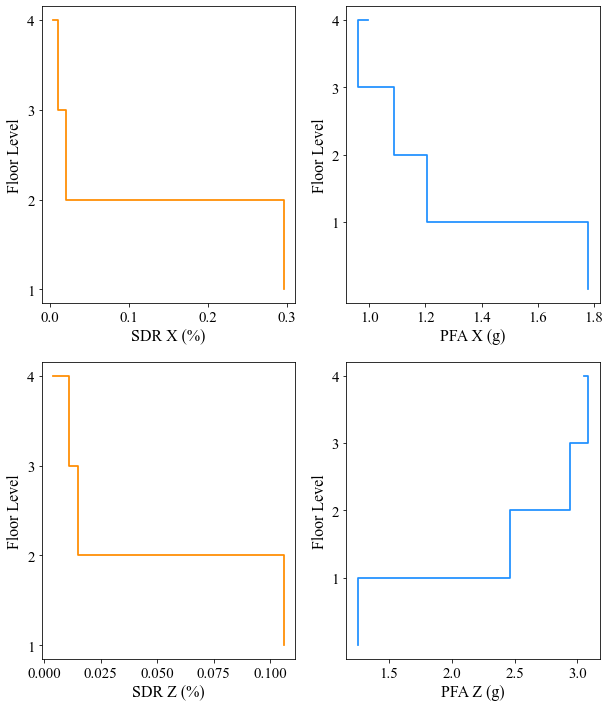

In [13]:
plot_edp_profile(baseDir, BuildingList, 9, pairingID=1,
                     combine_pairingIDs=False,
                     combine_biDirectional_edp=False, 
                 save_fig=False)